# Statystyczne metody przetwarzania danych 

## Laboratorium 2 - algorytm *k* Najbliższych Sąsiadów (*k*NN)


### Opis
Celem laboratorium jest implementacja klasyfikatora *k* najbliższych sąsiadów - *k*NN (*k Nearest Neighbors*) oraz zapoznanie się z innymi metrykami klasyfikacji.

### Termin
Zadanie należy wykonać tego samego dnia. 

### System oceniania

| Liczba punktów (procentowo) | Ocena |
| :----                    | ---: |
| [0-50)   | 2   |
| [50-60)  | 3   |
| [60-70)  | 3.5 |
| [70-80)  | 4   |
| [80-90)  | 4.5 |
| [90-100] | 5   |

<u>Punkty ujemne</u>

* `ocena - 0.5` jeżeli zadanie wysłano po laboratorium, ale < 7 dni; 
* `ocena - 1` jeżeli zadanie wysłano w terminie pomiędzy 7 a 14 dni;
* `ocena - 1.5` jeżeli zadanie wysłano po upływie 14 dni, ale przed ostatnim laboratorium;
* `ocena = 2` jeżeli zadanie wysłano po ostatnim laboratorium.

<u>Uwaga:</u>

Niedopuszczalne jest dzielenie się notatnikiem (plik `.ipynb`) z innymi studentami ani udostępnianie go w Internecie. Każdy student powinien pobrać notatnik samodzielnie z platformy WIKAMP.
Wysyłając zadanie potwierdasz, że wykonałeś je samodzielnie i jest to Twoja indywidualna praca a materiał przedstawiony w tej pracy jest dla Ciebie zrozumiały. Prace bardzo podobne albo grupowe będą uznawane za plagiat.


### Zbiór danych

Zbiór danych znajduje się w katalogu `dataset/*`. Jest to zmodyfikowany zbiór danych znajdujący się pod adresem: <https://archive.ics.uci.edu/ml/datasets/leaf>.

### Przesyłanie zadań

Wszystkie pliki należy spakować archiwizatorem **zip** i przesłać za pośrednictwem platformy WIKAMP. Poniżej oczekiwana zawartość archiwum:

```
+-- 📂 [IMIE.NAZWISKO].zip
    +-- 📜 Lab02.ipynb
    +-- 📂 dataset
        +-- 📜 dataset.npz
        +-- 📜 ReadMe.pdf
```

### Dodatkowe narzędzia

Dopuszczalne jest korzystanie z bibliotek: `numpy`, `pandas`, `matplotlib`.
Implementacja klasyfikatora powinna być wykonana samodzielnie (bez dodatkowych bibliotek).


### Zadanie

Należy wykonać następujące czynności w celu realizacji niniejszego zadania:
* Wczytaj dane.
* **Zaimplementuj klasyfikator *k* najbliższych sąsiadów (*k*NN)** i uruchom predykcję.
* Opisz jak zmieniają się wyniki klasyfikatora dla różnych wartości *k*, dla różnej liczby klas oraz dla różnej liczby cech.
* Wyświetl tablicę pomyłek (*confusion matrix*). W tym przypadku możesz zastosować gotową implementację z biblioteki `scikit-learn` <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html>.
* Odszukaj przynajmniej dwie inne (niż accuracy) metryki przytatne w klasyfikacji na stronie <https://scikit-learn.org/stable/modules/model_evaluation.html> i opisz ich wyniki. Wytłumacz czym się różnią i co można z nich odczytać.
* Opisz różnicę wyników klasyfikacji obu algorytmów (NN i *k*NN)?


> UWAGA: Wszystkie wykonane elementy zadania powinny posiadać stosowne komentarze i opisy.

### Wczytywanie danych

In [1]:
# Piotr Klimczak, 1SIiUM2, 239533 / 215275
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score

with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']

### Przygotowanie danych

In [2]:
columns_name = ['Class (Species)','Specimen Number','Eccentricity','Aspect Ratio','Elongation','Solidity',
                'Stochastic Convexity','Isoperimetric Factor','Maximal Indentation Depth','Lobedness',
                'Average Intensity','Average Contrast','Smoothness','Third moment','Uniformity','Entropy']

df_train = pd.DataFrame(train, columns = columns_name)
df_test = pd.DataFrame(test, columns = columns_name)

'''
df_train_groupby = df_train.groupby('Class (Species)').size().reset_index(name='Ile próbek train')
df_test_groupby = df_test.groupby('Class (Species)').size().reset_index(name='Ile próbek test')

pd.concat([df_train_groupby, df_test_groupby], axis=1)
'''

"\ndf_train_groupby = df_train.groupby('Class (Species)').size().reset_index(name='Ile próbek train')\ndf_test_groupby = df_test.groupby('Class (Species)').size().reset_index(name='Ile próbek test')\n\npd.concat([df_train_groupby, df_test_groupby], axis=1)\n"

### Wybrana klasa 3 i 5

In [3]:
nigra = df_train.loc[df_train['Class (Species)'] == 3.0] 
robur = df_train.loc[df_train['Class (Species)'] == 5.0]

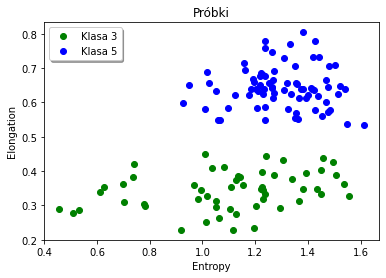

In [4]:
plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

#.to_numpy() - Convert the DataFrame to a NumPy array.
nigra_cecha1 = nigra[['Entropy']].to_numpy() 
nigra_cecha2 = nigra[['Elongation']].to_numpy()

robur_cecha1 = robur[['Entropy']].to_numpy()
robur_cecha2 = robur[['Elongation']].to_numpy()

plt.plot(nigra_cecha1,nigra_cecha2,"og",label='Klasa 3') 
plt.plot(robur_cecha1,robur_cecha2,"ob",label='Klasa 5') 
legend = plt.legend(loc='best', shadow=True, fontsize='medium')
plt.show()

### Funkcje dot. algorytmu

In [29]:
#loc[0]    # value at index label 0 - nazwane '0'
#iloc[0]   # value at index location 0 - czyli pierwszy element
#isin([3,5]) # zwraca True, jeżeli znajduje się (np. w Class (Species)) wartość 3 lub 5
#indexowanie w numpy: https://numpy.org/doc/stable/user/absolute_beginners.html#creating-matrices - [wiersze, kolumny]
#axis=0 |, axis=1 _

def NormalizowanieWzor(data,rows,cols):
    #(data - data.min) / (data.max / data.min)
    return ((data[rows,cols] - np.min(data[:,cols])) / (np.max(data[:,cols]) - np.min(data[:,cols])))

def Normalizowanie(data,data_normalized,num_rows,num_cols):
    #Normalizowanie danych:
    for b in range(num_cols):
        for a in range(num_rows):
            data_normalized[a,b] = NormalizowanieWzor(data,a,b)
    df = pd.DataFrame(data_normalized) #bo stosowane są komendy z pandas, typu iloc, wiec zamiana na DataFrame
    return(df)

def OdlegloscWzor(data_test,data_train,ile_test,ile_train,ile_cech):
    #Przydatne dla wiekszej ilosci cech niz np. 2, bo ten wzor sie rozrasta mocno
    zmienna = 0 #init 
    for i in range(ile_cech):
        zmienna += ((data_test.iloc[ile_test,i] - data_train.iloc[ile_train,i]) ** 2) #zsumuj wartosci
    return np.sqrt((zmienna)) #pierwiastek

#Normalizowanie zbiorów
def PrzygotujNormalizowanie(dane_we,cechy,klasy):
    dane = dane_we.loc[dane_we['Class (Species)'].isin(klasy)] #wybierz klase 3.0 i 5.0
    dane_attributes = dane[cechy].to_numpy() #wybieranie cech
    dane_num_rows, dane_num_cols = dane_attributes.shape #pobierz num_rows i num_cols z cech
    dane_attributes_normalized = np.empty([dane_num_rows,dane_num_cols]) #stworz nowy array o wymiarach jw. i znormalizuj
    dane_attributes_normalized = Normalizowanie(dane_attributes,dane_attributes_normalized,dane_num_rows,dane_num_cols)
    klasy = dane['Class (Species)'] #do klasyfikowania 
    return(dane_num_rows, dane_num_cols, dane_attributes_normalized, klasy, dane_attributes)

#Algorytm kNN
def Algorytm(k, klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy):
    top_k_wartosci = np.empty([k,1]) #bez tego, zmieniajac k, wyskakuje blad (poniewaz top_n_wartosci ma juz jakis rozmiar)
    wzor = np.empty([train_num_rows])
    klasyfikacja = np.empty([test_num_rows,1])
    
    for i in range(test_num_rows): #w zakresie TEST
    
        for j in range(train_num_rows): #w zakresie TRAIN
            wzor[j] = OdlegloscWzor(test_attributes_normalized,train_attributes_normalized,i,j,train_num_cols) #Ostatni argument moze byc i nn_test_num_cols
    
        min_indeksy = np.argsort(wzor,axis=0) #posortuj odleglosci indeksami malejaco, axis=0 - pionowo
        top_k_min_indeksy = min_indeksy[:k] #weź top K indeksow
    
        for x in range(k):
            top_k_wartosci[x] = klasy.iloc[top_k_min_indeksy[x]] #znajdz ich klasy
            unique, counts = np.unique(top_k_wartosci, return_counts=True) #znajdz, ile jest jakich klas
            polacz = dict(zip(unique, counts)) #polacz, by za pomoca max:

        klasa = max(polacz, key=polacz.get) #max, zwraca key (pierwsza wartosc w dict), gdzie value jest max (druga wartosc)
        klasyfikacja[i] = klasa #przypis do klasyfikacji

        zlaczone = np.concatenate((test_attributes,klasyfikacja),axis=1) #etykietowanie testowych x,y z klasyfikacja

        #Trochę zrobione "na sztywno", powinno to być bardziej uniwersalne, typu petla for dodająca znaki alfabetu (ASCII) odpowiednio tyle, ile trzeba
        if len(cechy) == 2:
            columns_nowe = ['x testowe','y testowe','klasyfikacja']
        else:
            columns_nowe = ['y','z','a','b','c','klasyfikacja']
                  
        nn_result = pd.DataFrame(zlaczone, columns = columns_nowe)
                                 
    return(nn_result)
                    
def Matrix(test,result):
    unique = np.unique([test.to_numpy(), result['klasyfikacja'].to_numpy()])
    print(type(test.to_numpy()[0]))
    print(result['klasyfikacja'].to_numpy())
    
    conmat = pd.DataFrame(
        confusion_matrix(test.to_numpy(), result['klasyfikacja'].to_numpy(), labels=unique),
        index = ['TRUE:{:}'.format(x) for x in unique],
        columns = ['PRED:{:}'.format(x) for x in unique]
    )
    
    print(conmat)
    
def RecallScore(test,result):
    rs = recall_score(test.to_numpy(), result['klasyfikacja'].to_numpy(), average='macro')
    return(rs)

def Kappa(test,result):
    kappa = cohen_kappa_score(test.to_numpy(), result['klasyfikacja'].to_numpy())
    return(kappa)

### kNN, k = 1, cechy = 2, klasy = 2 

In [30]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 1 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [3,5]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK
nn_result

Matrix(test_klasy, nn_result)

<class 'numpy.float64'>
[3. 3. 5. 5. 5. 3. 3. 5. 5. 3. 3. 3. 5. 5. 5. 3. 3. 5. 5. 3. 3. 3. 5. 5.
 5. 3. 3. 5. 5. 3. 3. 3. 5. 5. 5. 3. 3. 5. 5. 3. 3. 3. 5. 5. 5. 3. 3. 5.
 5. 3. 3. 3. 5. 5. 5. 3. 3. 5. 5. 3. 3. 3. 5. 5. 5. 3. 3. 5. 5. 3. 3. 3.
 5. 5. 5. 3. 3. 5. 5. 3. 3. 3. 5. 5. 5. 3. 3. 5. 5. 3. 3. 3. 5. 5. 5. 3.
 3. 5. 5. 3. 3. 3. 5. 5. 5. 3. 3. 5. 5. 3.]
          PRED:3.0  PRED:5.0
TRUE:3.0        55         0
TRUE:5.0         0        55


### Wynik algorytmu

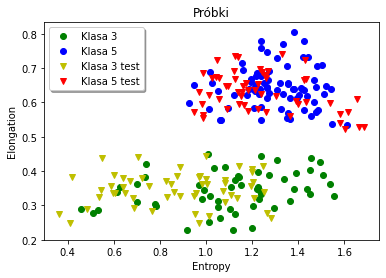

100.0 %


In [7]:
def PlotAfterNN(ktora_klasa):
    klasa = nn_result.loc[(nn_result['klasyfikacja'] == ktora_klasa)]
    cecha1 = klasa[['x testowe']].to_numpy()
    cecha2 = klasa[['y testowe']].to_numpy()
    return(cecha1,cecha2)

def Plot2Cechy():
    plt.figure()
    plt.title("Próbki")
    plt.xlabel(f"Entropy")
    plt.ylabel(f"Elongation")

    ncecha1_nn, ncecha2_nn = PlotAfterNN(3.0)
    rcecha1_nn, rcecha2_nn = PlotAfterNN(5.0)

    plt.plot(nigra_cecha1,nigra_cecha2,"og",label='Klasa 3') 
    plt.plot(robur_cecha1,robur_cecha2,"ob",label='Klasa 5') 

    plt.plot(ncecha1_nn,ncecha2_nn,"yv",label='Klasa 3 test') 
    plt.plot(rcecha1_nn,rcecha2_nn,"rv",label='Klasa 5 test') 
    legend = plt.legend(loc='best', shadow=True, fontsize='medium')
    plt.show()

def Dokladnosc():
    zgodne = 0 #init & czysc zmienna

    for i in range(test_num_rows):
        if ((test_klasy.to_numpy())[i]  == (nn_result['klasyfikacja'].to_numpy())[i]): #czy pokrywa się klasyfikacja
            zgodne += 1 #jeżeli tak, +1
        
    acc = zgodne / test_num_rows
    print(acc*100,'%')    
    
Plot2Cechy()
Dokladnosc()

### kNN, k = 5, cechy = 2, klasy = 2

In [8]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 5 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [3,5]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

          PRED:3.0  PRED:5.0
TRUE:3.0        55         0
TRUE:5.0         0        55


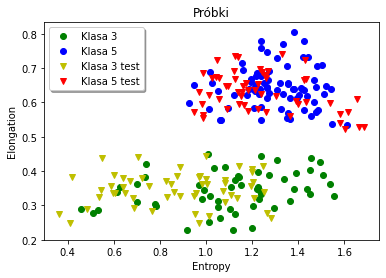

100.0 %


In [9]:
Plot2Cechy()
Dokladnosc()

### kNN, k = 9, cechy = 2, klasy = 2

In [9]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 9 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [3,5]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

          PRED:3.0  PRED:5.0
TRUE:3.0        55         0
TRUE:5.0         0        55


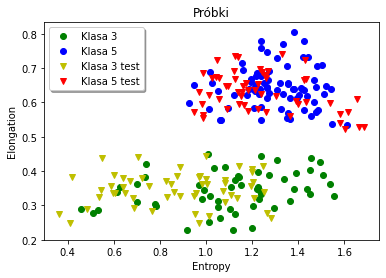

100.0 %


In [10]:
Plot2Cechy()
Dokladnosc()

### kNN, k = 15, cechy = 2, klasy = 2

In [11]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 15 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [3,5]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

          PRED:3.0  PRED:5.0
TRUE:3.0        55         0
TRUE:5.0         0        55


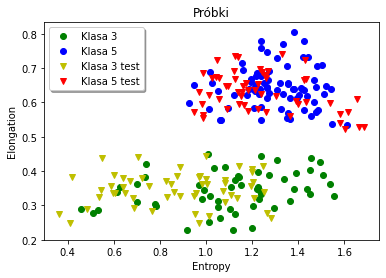

100.0 %


In [12]:
Plot2Cechy()
Dokladnosc()

### Przygotowanie do obsługi większej ilości cech i klas

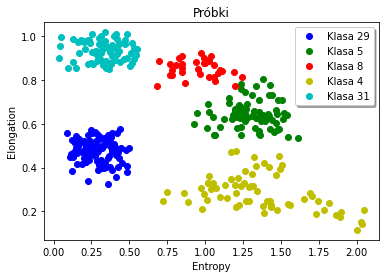

In [13]:
wszystkie = df_train.loc[(df_train['Class (Species)'].isin([29,5,8,4,31]))]

###########################################

plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

def Rysuj(ktora_klasa):
    kl = wszystkie.loc[df_train['Class (Species)'] == ktora_klasa] 
    kl_cecha1 = kl[['Entropy']].to_numpy() 
    kl_cecha2 = kl[['Elongation']].to_numpy()
    return(kl_cecha1, kl_cecha2)

kl29_cecha1, kl29_cecha2 = Rysuj(29.0)
kl5_cecha1, kl5_cecha2 = Rysuj(5.0)
kl8_cecha1, kl8_cecha2 = Rysuj(8.0)
kl4_cecha1, kl4_cecha2 = Rysuj(4.0)
kl31_cecha1, kl31_cecha2 = Rysuj(31.0)

plt.plot(kl29_cecha1,kl29_cecha2,"ob",label='Klasa 29') 
plt.plot(kl5_cecha1,kl5_cecha2,"og",label='Klasa 5') 
plt.plot(kl8_cecha1,kl8_cecha2,"or",label='Klasa 8') 
plt.plot(kl4_cecha1,kl4_cecha2,"oy",label='Klasa 4')  
plt.plot(kl31_cecha1,kl31_cecha2,"oc",label='Klasa 31') 

legend = plt.legend(loc='best', shadow=True, fontsize='medium')
plt.show()

## Więcej klas
### kNN, k = 1, cechy = 2, klasy = 5

In [14]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 1 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         21         0         0          1          0
TRUE:5.0          0        54         1          0          0
TRUE:8.0          0        11        68          0          9
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44


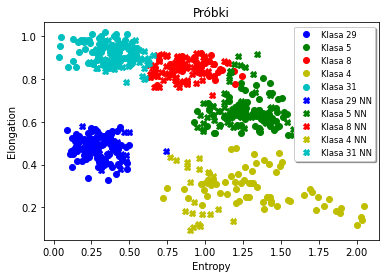

90.47619047619048 %


In [15]:
plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

kl29_cecha1_nn, kl29_cecha2_nn = PlotAfterNN(29.0)
kl5_cecha1_nn, kl5_cecha2_nn = PlotAfterNN(5.0)
kl8_cecha1_nn, kl8_cecha2_nn = PlotAfterNN(8.0)
kl4_cecha1_nn, kl4_cecha2_nn = PlotAfterNN(4.0)
kl31_cecha1_nn, kl31_cecha2_nn = PlotAfterNN(31.0)

plt.plot(kl29_cecha1,kl29_cecha2,"ob",label='Klasa 29') 
plt.plot(kl5_cecha1,kl5_cecha2,"og",label='Klasa 5') 
plt.plot(kl8_cecha1,kl8_cecha2,"or",label='Klasa 8') 
plt.plot(kl4_cecha1,kl4_cecha2,"oy",label='Klasa 4')  
plt.plot(kl31_cecha1,kl31_cecha2,"oc",label='Klasa 31') 

plt.plot(kl29_cecha1_nn,kl29_cecha2_nn,"Xb",label='Klasa 29 NN') 
plt.plot(kl5_cecha1_nn,kl5_cecha2_nn,"Xg",label='Klasa 5 NN') 
plt.plot(kl8_cecha1_nn,kl8_cecha2_nn,"Xr",label='Klasa 8 NN') 
plt.plot(kl4_cecha1_nn,kl4_cecha2_nn,"Xy",label='Klasa 4 NN')  
plt.plot(kl31_cecha1_nn,kl31_cecha2_nn,"Xc",label='Klasa 31 NN') 

legend = plt.legend(loc='best', shadow=True, fontsize='small')
plt.show()

Dokladnosc()

### kNN, k = 5, cechy = 2, klasy = 5

In [16]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 5 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         20         2         0          0          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0        10        66          0         12
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44


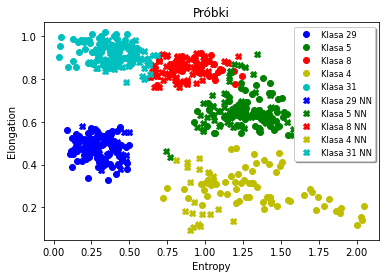

89.6103896103896 %


In [17]:
plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

kl29_cecha1_nn, kl29_cecha2_nn = PlotAfterNN(29.0)
kl5_cecha1_nn, kl5_cecha2_nn = PlotAfterNN(5.0)
kl8_cecha1_nn, kl8_cecha2_nn = PlotAfterNN(8.0)
kl4_cecha1_nn, kl4_cecha2_nn = PlotAfterNN(4.0)
kl31_cecha1_nn, kl31_cecha2_nn = PlotAfterNN(31.0)

plt.plot(kl29_cecha1,kl29_cecha2,"ob",label='Klasa 29') 
plt.plot(kl5_cecha1,kl5_cecha2,"og",label='Klasa 5') 
plt.plot(kl8_cecha1,kl8_cecha2,"or",label='Klasa 8') 
plt.plot(kl4_cecha1,kl4_cecha2,"oy",label='Klasa 4')  
plt.plot(kl31_cecha1,kl31_cecha2,"oc",label='Klasa 31') 

plt.plot(kl29_cecha1_nn,kl29_cecha2_nn,"Xb",label='Klasa 29 NN') 
plt.plot(kl5_cecha1_nn,kl5_cecha2_nn,"Xg",label='Klasa 5 NN') 
plt.plot(kl8_cecha1_nn,kl8_cecha2_nn,"Xr",label='Klasa 8 NN') 
plt.plot(kl4_cecha1_nn,kl4_cecha2_nn,"Xy",label='Klasa 4 NN')  
plt.plot(kl31_cecha1_nn,kl31_cecha2_nn,"Xc",label='Klasa 31 NN') 

legend = plt.legend(loc='best', shadow=True, fontsize='small')
plt.show()

Dokladnosc()

### kNN, k = 9, cechy = 2, klasy = 5

In [18]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 9 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         20         1         0          1          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0         6        71          0         11
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44


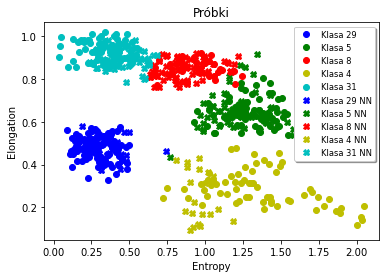

91.77489177489177 %


In [19]:
plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

kl29_cecha1_nn, kl29_cecha2_nn = PlotAfterNN(29.0)
kl5_cecha1_nn, kl5_cecha2_nn = PlotAfterNN(5.0)
kl8_cecha1_nn, kl8_cecha2_nn = PlotAfterNN(8.0)
kl4_cecha1_nn, kl4_cecha2_nn = PlotAfterNN(4.0)
kl31_cecha1_nn, kl31_cecha2_nn = PlotAfterNN(31.0)

plt.plot(kl29_cecha1,kl29_cecha2,"ob",label='Klasa 29') 
plt.plot(kl5_cecha1,kl5_cecha2,"og",label='Klasa 5') 
plt.plot(kl8_cecha1,kl8_cecha2,"or",label='Klasa 8') 
plt.plot(kl4_cecha1,kl4_cecha2,"oy",label='Klasa 4')  
plt.plot(kl31_cecha1,kl31_cecha2,"oc",label='Klasa 31') 

plt.plot(kl29_cecha1_nn,kl29_cecha2_nn,"Xb",label='Klasa 29 NN') 
plt.plot(kl5_cecha1_nn,kl5_cecha2_nn,"Xg",label='Klasa 5 NN') 
plt.plot(kl8_cecha1_nn,kl8_cecha2_nn,"Xr",label='Klasa 8 NN') 
plt.plot(kl4_cecha1_nn,kl4_cecha2_nn,"Xy",label='Klasa 4 NN')  
plt.plot(kl31_cecha1_nn,kl31_cecha2_nn,"Xc",label='Klasa 31 NN') 

legend = plt.legend(loc='best', shadow=True, fontsize='small')
plt.show()

Dokladnosc()

### kNN, k = 15, cechy = 2, klasy = 5

In [20]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 15 # KNN, określanie K
cechy = ['Entropy','Elongation']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         20         0         0          2          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0         8        67          0         13
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44


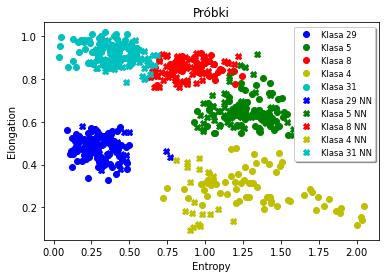

90.04329004329004 %


In [21]:
plt.figure()
plt.title("Próbki")
plt.xlabel(f"Entropy")
plt.ylabel(f"Elongation")

kl29_cecha1_nn, kl29_cecha2_nn = PlotAfterNN(29.0)
kl5_cecha1_nn, kl5_cecha2_nn = PlotAfterNN(5.0)
kl8_cecha1_nn, kl8_cecha2_nn = PlotAfterNN(8.0)
kl4_cecha1_nn, kl4_cecha2_nn = PlotAfterNN(4.0)
kl31_cecha1_nn, kl31_cecha2_nn = PlotAfterNN(31.0)

plt.plot(kl29_cecha1,kl29_cecha2,"ob",label='Klasa 29') 
plt.plot(kl5_cecha1,kl5_cecha2,"og",label='Klasa 5') 
plt.plot(kl8_cecha1,kl8_cecha2,"or",label='Klasa 8') 
plt.plot(kl4_cecha1,kl4_cecha2,"oy",label='Klasa 4')  
plt.plot(kl31_cecha1,kl31_cecha2,"oc",label='Klasa 31') 

plt.plot(kl29_cecha1_nn,kl29_cecha2_nn,"Xb",label='Klasa 29 NN') 
plt.plot(kl5_cecha1_nn,kl5_cecha2_nn,"Xg",label='Klasa 5 NN') 
plt.plot(kl8_cecha1_nn,kl8_cecha2_nn,"Xr",label='Klasa 8 NN') 
plt.plot(kl4_cecha1_nn,kl4_cecha2_nn,"Xy",label='Klasa 4 NN')  
plt.plot(kl31_cecha1_nn,kl31_cecha2_nn,"Xc",label='Klasa 31 NN') 

legend = plt.legend(loc='best', shadow=True, fontsize='small')
plt.show()

Dokladnosc()

## Więcej cech i klas
### kNN, k = 1, cechy = 5, klasy = 5

In [22]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 1 # KNN, określanie K
cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

Dokladnosc()

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         19         3         0          0          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0         0        77          0         11
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44
93.93939393939394 %


### kNN, k = 5, cechy = 5, klasy = 5

In [23]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 5 # KNN, określanie K
cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

Dokladnosc()

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         18         3         0          1          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0         0        83          0          5
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44
96.1038961038961 %


### kNN, k = 9, cechy = 5, klasy = 5

In [25]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 9 # KNN, określanie K
cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

Dokladnosc()

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         18         3         0          1          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0         1        83          0          4
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44
96.1038961038961 %


### kNN, k = 15, cechy = 5, klasy = 5

In [26]:
## ZDEFINIUJ PARAMETRY TUTAJ:

k = 15 # KNN, określanie K
cechy = ['Elongation','Entropy','Aspect Ratio','Lobedness','Solidity']
klasy = [29,5,8,4,31]

### LICZENIE
train_num_rows, train_num_cols, train_attributes_normalized, train_klasy, train_attributes = PrzygotujNormalizowanie(df_train,cechy,klasy)
test_num_rows, test_num_cols, test_attributes_normalized, test_klasy, test_attributes = PrzygotujNormalizowanie(df_test,cechy,klasy)
nn_result = Algorytm(k, train_klasy, test_num_rows, train_num_rows, test_attributes_normalized, train_attributes_normalized, train_num_cols, test_attributes, cechy)

### WYNIK

nn_result

Matrix(test_klasy, nn_result)

Dokladnosc()

           PRED:4.0  PRED:5.0  PRED:8.0  PRED:29.0  PRED:31.0
TRUE:4.0         18         2         0          2          0
TRUE:5.0          0        55         0          0          0
TRUE:8.0          0         0        85          0          3
TRUE:29.0         0         0         0         22          0
TRUE:31.0         0         0         0          0         44
96.96969696969697 %


## Wnioski

Udało się poprawnie zaimplementować algorytm kNN. Dla k=1 jest to odpowiednik algorytmu NN. Poniżej wyniki symulacji:

**Dla 2 cech i 2 klas**:
- k=1 - wynik 100%
- k=5 - wynik 100%
- k=9 - wynik 100%
- k=15 - wynik 100%

Dopiero dla k=87 (nie pokazano już w skrypcie, lecz wyznaczyłem to eksperymentalnie; k bardzo duże, porównując, iż liczba próbek to 110) jedna próbka została źle zakwalifikowana, co daje wynik 99.09%
Wynik średni to 100%.

**Dla 2 cech i 5 klas**:
- k=1 - wynik 90.48%
- k=5 - wynik 89.61%
- k=9 - wynik 91.77%
- k=15 - wynik 90.04%

Jak widać, wynik średni oscyluje w granicach 90%.

**Dla 5 cech i 5 klas**:
- k=1 - wynik 93.94%
- k=5 - wynik 96.10%
- k=9 - wynik 96.10%
- k=15 - wynik 96.96%

Metoda jest złożona obliczeniowo bardzo mocno. Dla 5 cech i 5 klas algorytm potrafi wykonywać się około 1-2 minuty.

Jak można zauważyc z pomiarów, daje ona zbliżone wartości dokładności jak i algorytm NN, _lecz_ im więcej mamy cech i jak dobierze się odpowiednie k, można uzyskać lepsze wyniki (głównie o widać przy 5 cechach i 5 klasach, gdzie wynik jest wyższy o ok. 3% niż w przypadku NN)


### Sklearn

Wyświetl tablicę pomyłek (confusion matrix). W tym przypadku możesz zastosować gotową implementację z biblioteki scikit-learn

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html.

Odszukaj przynajmniej dwie inne (niż accuracy) metryki przytatne w klasyfikacji na stronie https://scikit-learn.org/stable/modules/model_evaluation.html i opisz ich wyniki. Wytłumacz czym się różnią i co można z nich odczytać.

Confusion matrix został zaimplementowany jako funkcja i policzony pod każdym przykładem.

Znalazłem także 2 koleje metryki:

- Współczynnik recall - wartość najlepsza to 1, najgorsza to 0
tp / (tp + fn), gdzie tp to 'true positives' a fp to 'false negatives'

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
 
 >y_true = [0, 1, 2, 0, 1, 2]
 
 >y_pred = [0, 2, 1, 0, 0, 1]
 
 >recall_score(y_true, y_pred, average=None)
 >zmieniajac None na inne, np macro - Calculate metrics globally by counting the total true positives, false negatives and false positives - co zastosowalem u siebie w kodzie
 
 >wynik: array([1., 0., 0.]) 
 >1 bo 0 sie zgadza zawsze, pozostale nie

- współczynnik Kappa Cohea - przyjmuje wartości od -1 do 1, gdzie wartości od -1 do 0 są praktycznie niewykorzystywane
ujemna wartość oznaczałaby zgodność ocen mniejszą, niż gdyby były one całkowicie losowe.

https://pl.wikipedia.org/wiki/Kappa_Cohena

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score

By nie zaciemniać pracy, postanowiono obliczyć tylko poniżej (dla ostatniego przykładu, k=15, 5 cech i 5 klas):

In [28]:
RecallScore(test_klasy, nn_result)

0.9568181818181818

In [29]:
Kappa(test_klasy, nn_result)

0.9593248478140565